# ASUM

In [1]:
import os
import pandas as pd
from collections import Counter 
from wordcloud import WordCloud

import sys;
sys.path.append('..')

from reviews.preprocess import preprocess
from reviews.config import out_dir, processed_data_dir, raw_data_dir, asum_input_dir, asum_output_dir

In [2]:
# read data
df = pd.read_json(processed_data_dir / "reviews_digital_cameras.json.gz", orient="records")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df = df.sample(5000) # subset

df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   overall    2 non-null      int64 
 1   vote       2 non-null      int64 
 2   asin       2 non-null      object
 3   text       2 non-null      object
 4   summary    2 non-null      object
 5   timestamp  2 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 224.0+ bytes


## Preprocessing

In [3]:
# apply preprocessing
df["preprocess"] = df["text"].apply(lambda x : preprocess(x))

In [4]:
tokens = [word for doc in df["preprocess"] for sent in doc for word in sent]
c = Counter(tokens)

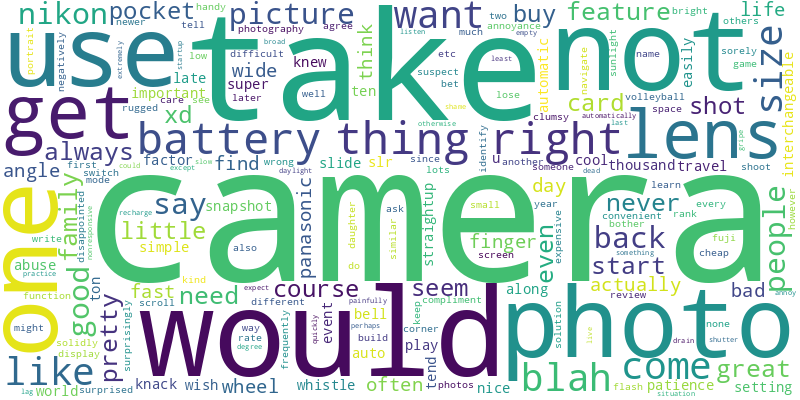

In [5]:
# generate the word cloud
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

In [6]:
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))
print(len(vocabulary))

198


## Generate data for ASUM

In [7]:
with open(asum_input_dir / "WordList.txt", "w") as f:
  for word in vocabulary:
    f.write(f"{word}\n")

In [8]:
sentence_list = asum_input_dir / "BagOfSentences.txt"

if os.path.exists(sentence_list):
  os.remove(sentence_list)

with open(sentence_list, "a") as f:
  for doc in df["preprocess"]:
    f.write(f"{len(doc)}\n")
    for tokens in doc:
      indexes = " ".join([str(vocabulary[t]) for t in tokens])
      f.write(f"{indexes}\n")

In [9]:
from reviews.models import asum

asum(asum_input_dir, asum_output_dir, "0.1", "0.001/0.1/0", "1/1", "5", iterations="500")

Documents: 2
Unique Words: 198
Documents: 2
Unique Words: 198
Topics: 5
Sentiments: 2 (dictionary: 2)
Alpha: 0.1
Beta: 
0.001 0.1 0 
Gamma: 1 1 
Iterations: 500
Threads: 3
Input Dir: ../data/asum
Dictionary Dir: ../data/asum
Output Dir: ../output/asum
Too Long Sentences: 0
Gibbs sampling started (Iterations: 500, Threads: 3)
  - Iteration 0
right/2/0/ compliment/1/0/ great/1/0/ patience/1/0/ handy/1/0/ convenient/0/0/ fast/1/0/ like/1/0/ bright/0/0/ cool/1/0/ nice/1/0/ pretty/2/0/ good/3/0/ well/0/0/ super/1/0/ important/1/0/ 
lose/0/1/ lag/0/1/ blah/0/0/ suspect/0/0/ abuse/0/1/ nonresponsive/0/0/ cheap/0/0/ annoyance/0/1/ gripe/0/1/ difficult/0/0/ bad/0/2/ bother/0/0/ sorely/0/1/ shame/0/1/ wrong/0/0/ disappointed/0/1/ painfully/0/0/ expensive/0/0/ annoy/0/0/ dead/0/0/ drain/0/1/ clumsy/0/0/ slow/0/0/ 
    Iteration 0 took 0.001s. (Estimated Time: 0h 0m)
  - Iteration 1
right/2/0/ compliment/1/0/ great/1/0/ patience/1/0/ handy/1/0/ convenient/0/0/ fast/1/0/ like/1/0/ bright/0/0/ cool/

## Print Values

In [10]:
df = pd.read_csv(
    asum_output_dir / "STO2-T10-S2(2)-A0.1-B0.001,0.1,0.0-G1.0,1.0-I500-ProbWords.csv"
)

def map_topic_sentiment(column_name):
  if ("Unnamed" in column_name):
    return None

  values = column_name.split("-")
  return {"sentiment": int(values[0][1]), "topic": int(values[1][1]), "colname": column_name }

columns = df.columns.map(map_topic_sentiment)

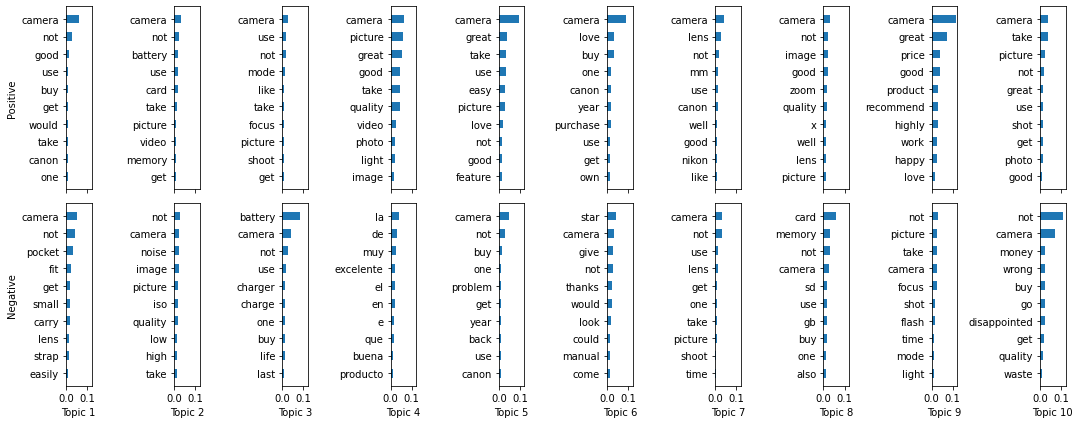

In [11]:
import matplotlib.pyplot as plt
import re

def get_word_weight(item):
  match = re.match("(\w+)\s+\((.*?)\)", item)
  word, weight = match.groups()
  return word, float(weight)

n_top_words = 10

fig, axes = plt.subplots(2, n_top_words, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for idx, item in enumerate(columns):
  if item is None:
    continue
  
  ax = axes[idx]
  words = df[item["colname"]][:n_top_words]
  weights = list(map(list, zip(*words.map(get_word_weight))))

  weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
  weights.sort_values("weights", inplace=True)
  
  ax.barh(weights["names"], weights["weights"], height=0.5)
  
  if idx > n_top_words - 1:
    ax.set_xlabel(f"Topic {item['topic'] + 1}")

  if idx == 0 or idx == n_top_words:
    ax.set_ylabel("Positive" if item['sentiment'] == 0 else "Negative")
fig.tight_layout()